In [27]:
import fnmatch, re, os
import json

def parametrizedFileSelection(fileDirectory, fileArguments):
    files = []
    
    for k,v in fileArgs.items():
        if type(v) is not list:
            fileArgs[k] = [v]
        
    for file in os.listdir(fileDirectory):
        if not os.path.isdir(fileDirectory+file):
            match = True
            for key in fileArguments:
                match = False
                for value in fileArguments[key]:
                    expression = key + "=" + str(value)
                    if expression + ',' in file or expression + '_' in file:
                        match = True
                if match == False:
                    break

            if match == True:
                files.append(fileDirectory+file)
        
    return files


# Experiment factors
Communs
- filename
- nWorkers
------- order based ------------
- voterSeed
- nVoters
--------Community detection based----------
- comDet
- assignment
- withBoundary (false si order based)
--------- Other ----------
- distType (close/far)
- minDist 

Pour un même nombre de worker on fait varier la seed (cas order based)

In [28]:
import pandas as pd
import numpy as np

fileDirectories = ["../outputs/facebook_combined_NA_0_100/","../outputs/facebook_combined_1k_3kWorkers_NA_0_5/"]

# fileArgs = { "nWorkers": 10, "voterSeed": 0, "minDist": "1"}
fileArgs = {}      
files = [parametrizedFileSelection(fileDirectory, fileArgs) for fileDirectory in fileDirectories]

filesData = []
for dirFiles in files:
    for file in dirFiles:
        with open(file) as json_file:
            data = json.load(json_file)
            filesData.append(data)        
       # print(len(data['candidates'][0]) ,"-", len(data['candidates']), data['candidates'])
df = pd.DataFrame(filesData)

In [29]:
def boxPlotAndHist(data,plotData, imgPath=None):
    fig, ax = plt.subplots(ncols=2)
    ax[0].set_title(plotData["title"])
    ax[0].set_yscale('log')
    ax[0].boxplot(data)

    ax[1].set_title(plotData["title"])
    ax[1].set_xscale('log')
    ax[1].set_yscale('log')
    ax[1].set_xlabel(plotData["title"])
    
    upperBound=data.quantile(0.9)
    ax[1].hist(data, bins=np.arange(0,upperBound+2,1))
    if imgPath is not None:
        fig.savefig(imgPath)
    plt.close(fig)

In [31]:
import matplotlib.pyplot as plt

largestCliqueSize = lambda x : len(x[0])
largestCliqueCount = lambda x : len(x)

largestCliqueSizeData = df["candidates"].apply(largestCliqueSize)
largestCliqueCountData = df["candidates"].apply(largestCliqueCount)

plotData={"title":"CliqueSize"}

boxPlotAndHist(largestCliqueSizeData,plotData)

plotData={"title":"CliqueCount"}

boxPlotAndHist(largestCliqueCountData,plotData)

## Distribution du nombre de workers distants en fonction de la seed utilisée

In [32]:
def distDistrib(df,seedFilter,clusterDistKey,imgPath=None):
    otherWorkersDistance = lambda x : x[clusterDistKey]
    
    data = []
    for seed in seedFilter:
        filterOnSeed = df.where(df["voterSeed"] == seed).dropna()
        otherWorkersDistanceData = filterOnSeed.head(1)["workerDistances"].apply(otherWorkersDistance)
        if len(otherWorkersDistanceData)>0:
            data.append(otherWorkersDistanceData.tolist()[0]) 
    newData = np.zeros((len(seedFilter),10), dtype=int)

    for x,l in enumerate(data):
        for y in range(0,len(l)):
            newData[x][y] = l[y]
            
    df2 = pd.DataFrame(newData, columns=range(-1,9))

    df2 = df2.apply(lambda x : x//2) #remove bidirectionnal links

    fig1, ax1 = plt.subplots(nrows=5, ncols=2, figsize=(4*2,3*5))
    for index, column in enumerate(df2.columns):
        ax1[index//2][index%2].set_title('Distance = ' + str(column))
        ax1[index//2][index%2].hist(df2[column])
        ax1[index//2][index%2].set_yscale("log")
        
    if imgPath is not None:
        fig1.savefig(imgPath)
    #plt.close(fig1)

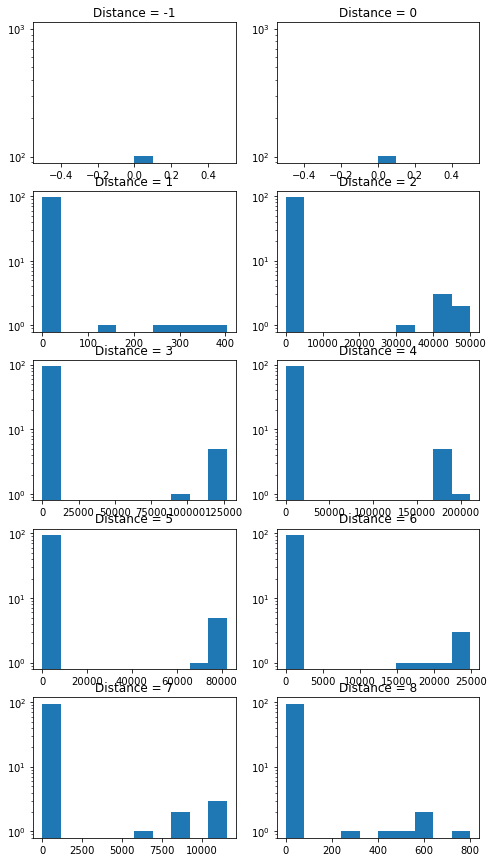

In [33]:
from scipy import stats
import numpy as np

seedFilter = ["NA",*list(range(0,100))]
#seedFilter = 
clusterDistKey="other"
distDistrib(df,seedFilter,clusterDistKey,imgPath=None)


Commentaire : pas de loi normale (pour l'instant) -> a tester avec les 100 seeds

## Evolution du nombre de workers dans les cliques maximales en fonction de la distance maximale entre workers

In [34]:
def formatToDict(df):
    candidatesByMinDist = {}
    for idx, row in df.iterrows():
        candidatesByMinDist[row["minDist"]] = row["candidates"]
    return candidatesByMinDist

In [46]:
df.head()
df = df[[
    'filename',
    'nWorkers',
    'voterSeed',
    'comDet',
    'assignment',
    'withBoundary',
    'distType',
    'candidates',
    'minDist'
]]
#print(df)
cols = df.columns[:-2].tolist()
nw=[#10,16,43,70,114,186,304,495,807,
    *[200*i for i in range(5,16)]]
print(nw)
conditions=[df["voterSeed"].isin(["NA"])\
            & df["withBoundary"].isin([True])\
            & df["assignment"].isin(["sizeProRataWorkerAssignement"])\
            & df["comDet"].isin(["community_multilevel"])\
            & df["nWorkers"].isin(nw)\
            ,

            ~df["voterSeed"].isin(["NA"])\
            & df["nWorkers"].isin(nw)\
            & df["assignment"].isin(["generateArrangementNumber"])
           ]
cliqueSizes=[]
for condition in conditions:
    groupDf = df.where(condition).dropna().groupby(by=cols)[['candidates', 'minDist']].apply(formatToDict)
    cliqueNumber = [ { k:len(v) for k,v in element.items() } for element in groupDf ]
    cliqueSize = [ { k:len(v[0]) for k,v in element.items() } for element in groupDf ]
    cliqueSizes.append(cliqueSize)
#print(cliqueSizes)

[1000, 1200, 1400, 1600, 1800, 2000, 2200, 2400, 2600, 2800, 3000]


for index, row in enumerate(groupDf):
    fig,ax = plt.subplots(nrows = 1, ncols = 1,figsize=(4,3))
    fig.suptitle("Clique number by minDist", fontsize=18)
    ax.plot(cliqueNumber[index].keys(), cliqueNumber[index].values())
    ax.set_title(',\n'.join(str(groupDf.keys()[index]).split(', ')))

for index, row in enumerate(groupDf):
    fig,ax = plt.subplots(nrows = 1, ncols = 1,figsize=(4,3))
    fig.suptitle("Clique size by minDist", fontsize=18)
    ax.plot(cliqueNumber[index].keys(), cliqueSize[index].values())
    ax.set_title(',\n'.join(str(groupDf.keys()[index]).split(', ')))

## Determination d'un k tq à 95% il n'y ait pas de worker colusion

In [47]:
def workerThreshold(cliqueSize, minDist, threshold, plotData, imgPath = None):

    maxCliqueSize = max([max(cs) for cs in cliqueSize])
    minCliqueSize = min([min(cs) for cs in cliqueSize])
    
    fig1, ax1 = plt.subplots(nrows=1, ncols=1, figsize = (10,6))
    
    
    ##todo faire apparaitre le nb de workers considéré (ici 807)
    fig1.suptitle(plotData["suptitle"], fontsize=18)

    bins=np.arange(minCliqueSize,maxCliqueSize+2, step=1)

    #ax1[0].hist(cliqueSize, bins=bins)
    #ax1[0].grid(linestyle=':')
    #ax1[0].set_yscale("log")
    bar_heights_list, _, _ = ax1.hist(cliqueSize, cumulative=True, density=True, bins = bins, histtype="step", label=[
                                #"withBoundary",
                                #"withoutBoundary",
        
                                #"sizeProRata",
                                #"sizeOrderedRoundRobin",
                                #"diameterProRata",
                                #"diameter",
                                #"nodeEdgeRatioProRata",
                                #"nodeDensityRatioProRata",
                                #"arrangementNumbering"
                                "sizeOrderedRoundRobinLP",
                                "nodeEdgeRatioProRataLP",
                                     "sizeProRataML",
                                "nodeDensityRatioProRataML",
                                "arrangementNumbering",
        ])
    xThresholds=[]
    for bar_heights in bar_heights_list:
        xThreshold = 0
        for index, v in enumerate(bar_heights):
            if v >= threshold:
                xThreshold = bins[index]
                break
        ax1.axhline(threshold, color='r', linestyle='dashed', linewidth=1)
        #ax1.axvline(xThreshold, color='r', linestyle='dashed', linewidth=1)
        
        #ax1.text(xThreshold + 0.7, 0.025, xThreshold).set_color('red')
        ax1.plot(xThreshold,threshold, marker='x')
        ax1.annotate(xThreshold, xy=(xThreshold,threshold), textcoords='data')
        ax1.legend(loc='lower right')
        xThresholds.append(xThreshold)
        
    #ax1.text(minCliqueSize-1, threshold + 0.02 , threshold).set_color('red')
    
    ax1.set_title(plotData["title"])
    ax1.minorticks_on()
    ax1.grid(which="major",linestyle='-')
    ax1.grid(which="minor",linestyle=':')
    ax1.set_xlabel("Amount of workers in the maximal clique")
    ax1.set_ylabel("% of executions for which |maxClique| <= x workers")
    if imgPath is not None:
        fig1.savefig(imgPath)
            
    return xThresholds


[28, 56]


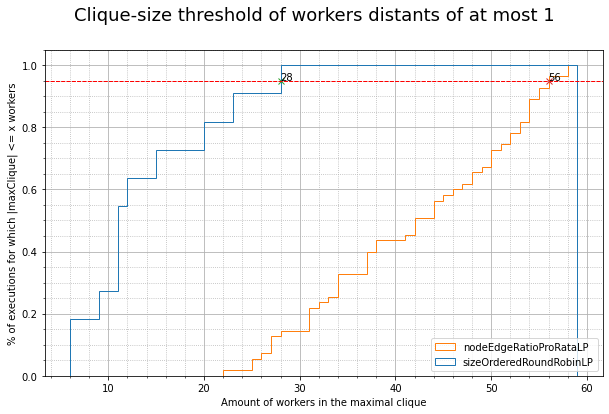

In [49]:
threshold=0.95
for minDist in range(1,2):
    cliqueSizeByMinDist = [[ element.get(minDist) for element in cliqueSize if element.get(minDist) is not None]
                              for cliqueSize in cliqueSizes]
    plotData={"suptitle":"Clique-size threshold of workers distants of at most {}".format(minDist),
             "title":"".format(minDist, threshold),
             }
    thresholds=workerThreshold(cliqueSizeByMinDist, minDist, threshold,plotData)
    print(thresholds)

Pour que 95% des executions n'aient pas de collusion il faut un nombre de workers t (sur n workers) min de xThreshold pour une minDist donnée 

Ici pour un distance maximale interworkers de 3 on a 95% des executions dont la clique maximale comprend 390 workers sur 807
Ainsi si on considère qu'une clique est potentiellement malveillante avec des workers de distance maximale de 3 il faudra prendre au moins 390 workers parmis les 807

Trouver la racine positive du polynome x² + x - nWorkers pour trouver la borne maximale de workers malveillants

Le seuil de workers malveillants est de 27 sur un total de 807 workers et de + de 4000 votants
Ce nombre respecte la contrainte du (n-t²) workers inactifs

Note par rapport aux résultats sur la détéction de communauté vs Order based : Des résultats en seuils assez similaire, cependant on observe pour la partie CD une hausse beaucoup plus linéaire du % par rapport au nb de noeuds dans la clique 

1, 1, 1, 1, 1, 1, 2
2, 3, 3, 3, 3, 3, 5
3, 3, 3, 3, 3, 3, 7
16w
1, 1, 1, 1, 1, 1, 3
3, 4, 4, 4, 3, 4, 8
4, 6, 6, 6, 3, 6, 11
43w
1, 2, 1, 2, 1, 1, 4
8, 10, 11, 11, 3, 9, 16
13, 17, 19, 20, 3, 14, 24
70w
1, 2, 2, 2, 3, 1, 5
13, 17, 18, 18, 13, 17, 24
24, 26, 31, 32, 23, 23, 38
114w
2, 3, 2, 3, 6, 1, 6
25, 28, 30, 29, 20, 30, 37
44, 43, 52, 52, 36, 36, 61
186w
2, 7, 3, 5, 11, 1, 9
43, 46, 48, 47, 34, 51, 55
75, 70, 85, 83, 57, 58, 97
304w
4, 13, 7, 10, 13, 1, 13
72, 76, 81, 76, 59, 86, 94
127, 114, 140, 136, 90, 95, 155
495w
4, 18, 12, 18, 18, 2, 17
121, 118, 132, 126, 90, 140, 145
212, 186, 229, 222, 162, 154, 245
807w
4, 18, 19, 18, 18, 4, 24
199, 190, 221, 215, 168, 232, 227
353, 306, 373, 364, 286, 257, 390

Empty DataFrame
Columns: []
Index: []
[1, 1]
[1, 1]
[1, 1]
[1, 1]
[1, 1]
[1, 1]
[2, 2]
[3, 3]
[4, 4]
[6, 6]
[6, 6]
[9, 9]
[11, 11]
[11, 11]
[11, 11]
[12, 12]
[15, 15]
[20, 20]
[23, 23]
[28, 28]


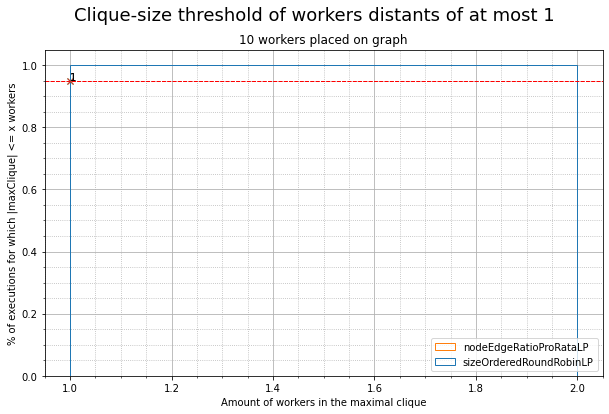

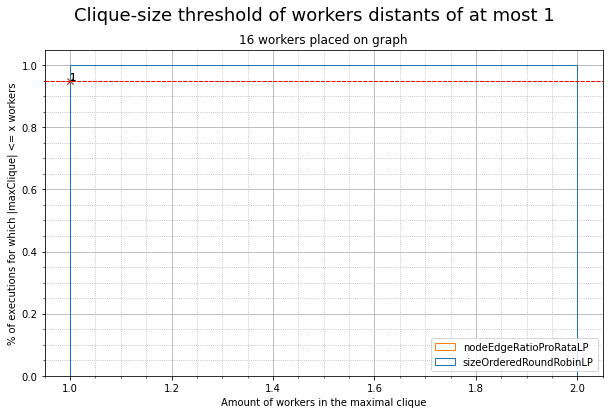

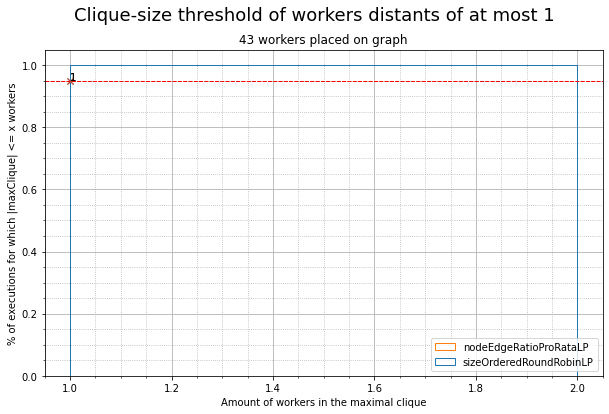

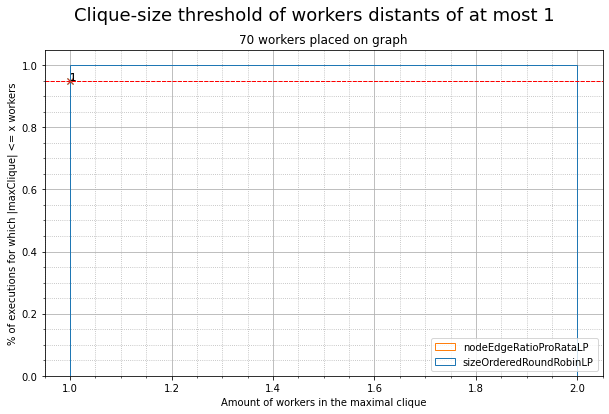

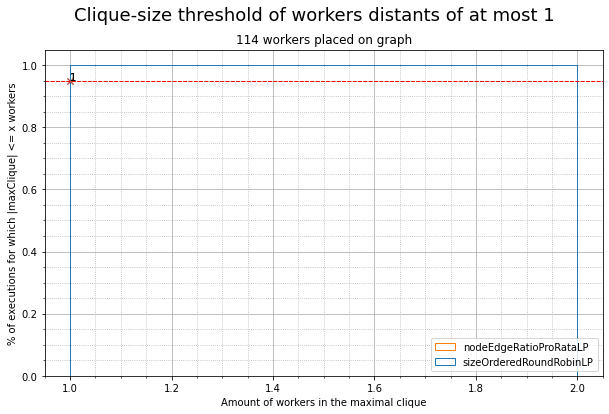

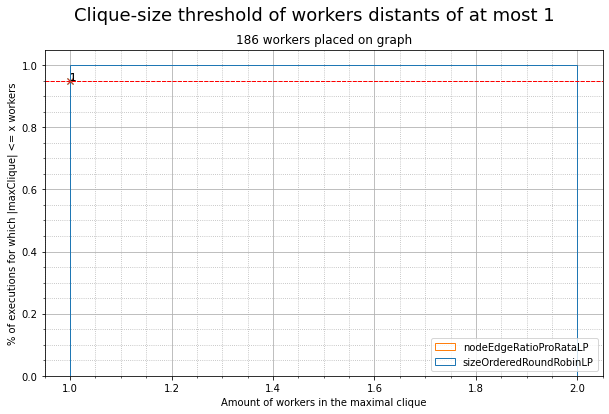

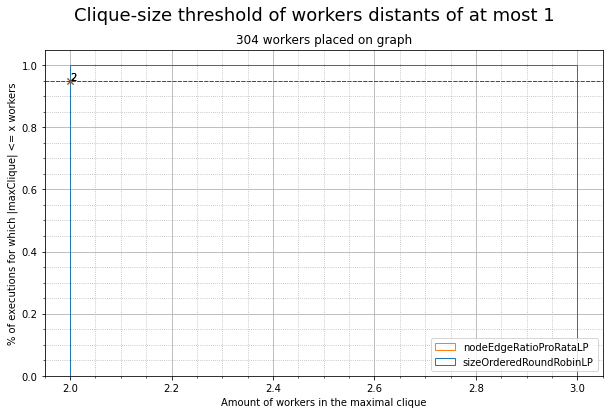

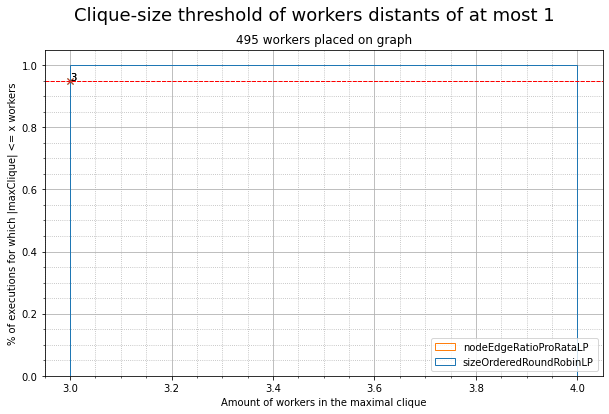

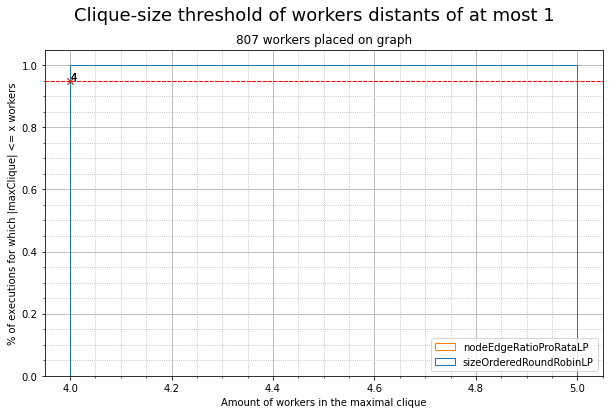

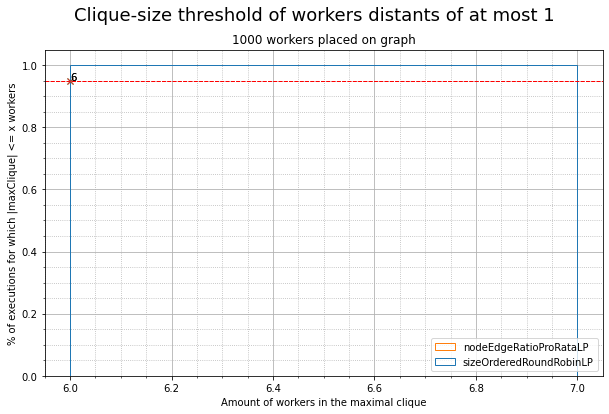

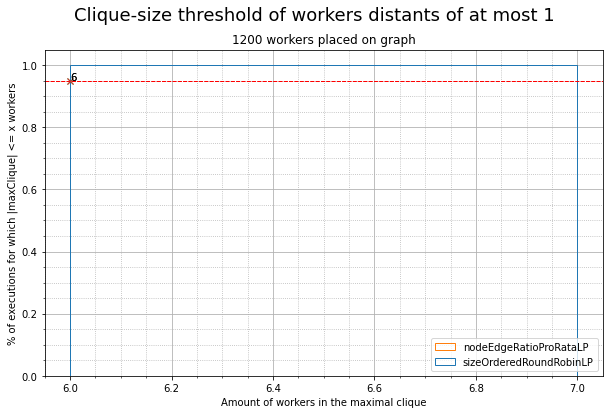

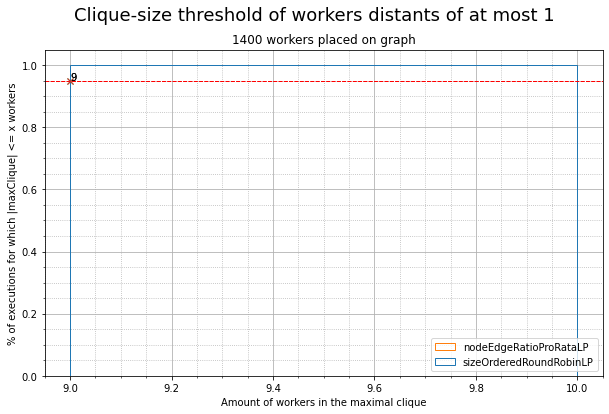

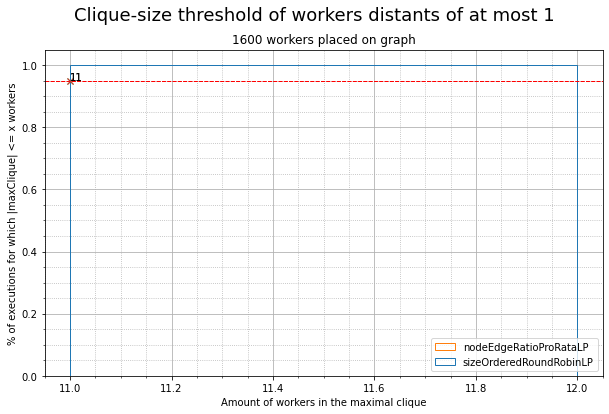

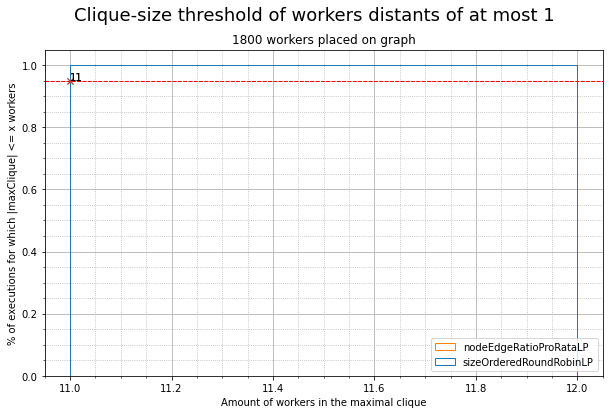

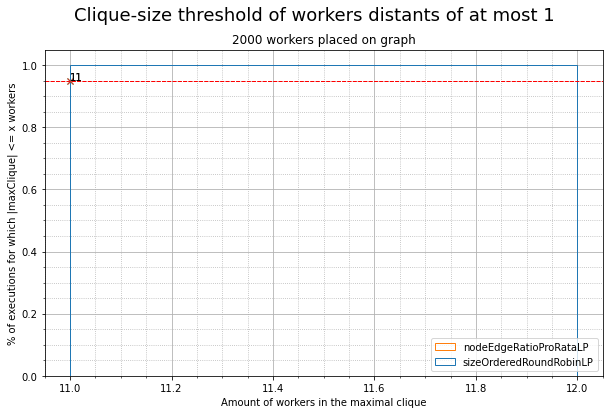

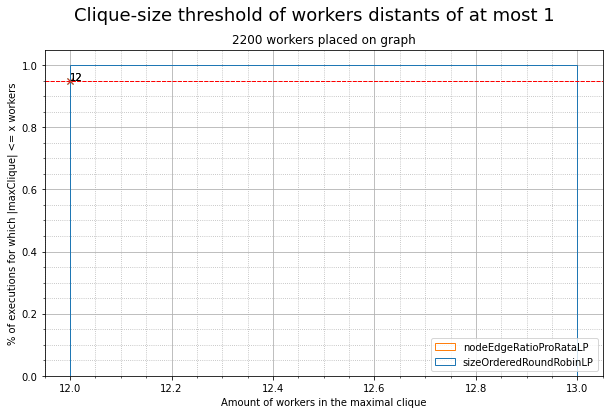

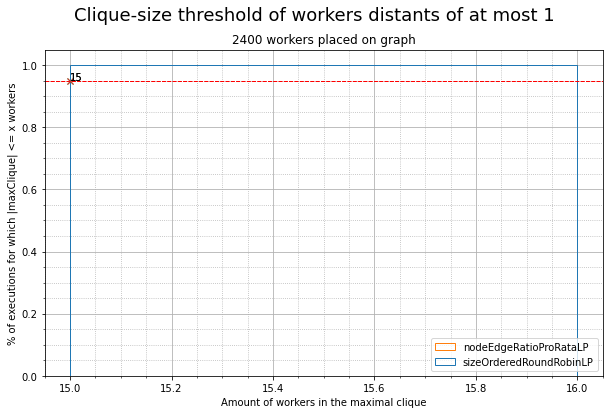

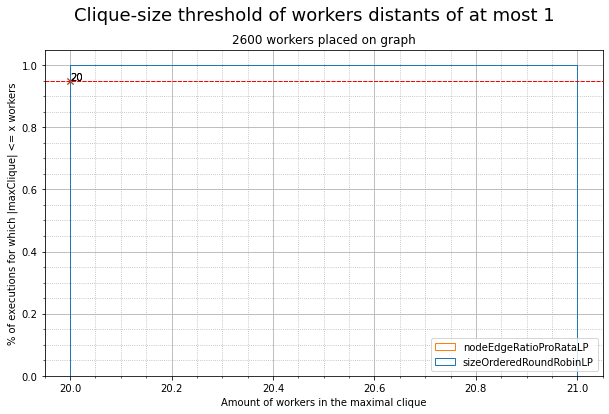

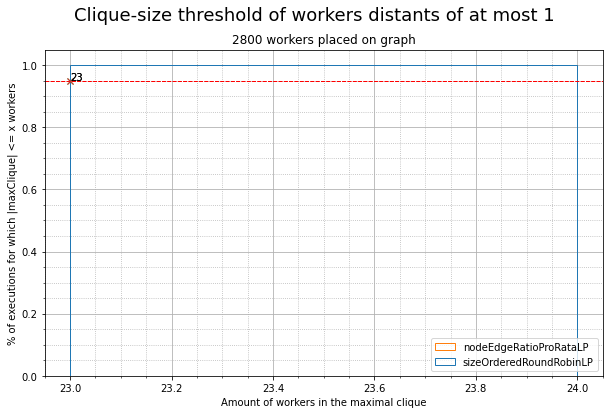

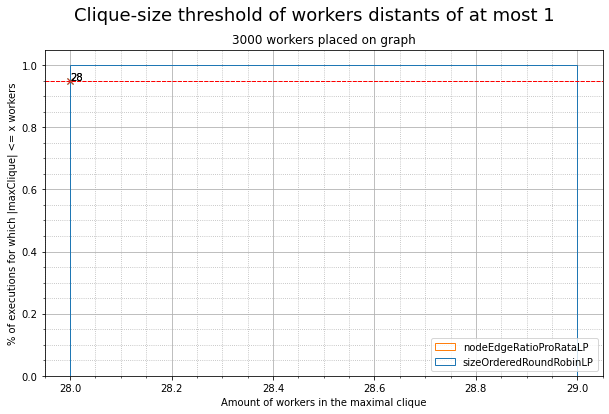

In [326]:

df.head()
df = df[[
    'filename',
    'nWorkers',
    'voterSeed',
    'comDet',
    'assignment',
    'withBoundary',
    'distType',
    'candidates',
    'minDist'
]]
#print(df)
cols = df.columns[:-2].tolist()
maxCliquesPerWorkersandMethod=pd.DataFrame()
print(maxCliquesPerWorkersandMethod)
for nw in [10,16,43,70,114,186,304,495,807,
          *[200*i for i in range(5,16)]
          ]:
    conditions=[
        
        df["voterSeed"].isin(["NA"])\
            & df["withBoundary"].isin([True])\
            & df["assignment"].isin(["sizeProRataWorkerAssignement"])\
            & df["comDet"].isin(["community_multilevel"])\
            & df["nWorkers"].isin([nw])\
            
            ,
        df["voterSeed"].isin(["NA"])\
            & df["withBoundary"].isin([True])\
            & df["assignment"].isin(["sizeProRataWorkerAssignement"])\
            & df["comDet"].isin(["community_multilevel"])\
            & df["nWorkers"].isin([nw])\
            
            ,
            #~df["voterSeed"].isin(["NA"])\
            #& df["nWorkers"].isin([nw])\
            #& df["assignment"].isin(["generateArrangementNumber"])
               ]
    cliqueSizes=[]
    for condition in conditions:
        groupDf = df.where(condition).dropna().groupby(by=cols)[['candidates', 'minDist']].apply(formatToDict)
        cliqueNumber = [ { k:len(v) for k,v in element.items() } for element in groupDf ]
        cliqueSize = [ { k:len(v[0]) for k,v in element.items() } for element in groupDf ]
        cliqueSizes.append(cliqueSize)
    #print(cliqueSizes)
    threshold=0.95
    for minDist in range(1,2):
        cliqueSizeByMinDist = [[ element.get(minDist) for element in cliqueSize if element.get(minDist) is not None]
                                  for cliqueSize in cliqueSizes]
        plotData={"suptitle":"Clique-size threshold of workers distants of at most {}".format(minDist),
                 "title":"{} workers placed on graph".format(nw),
                 }
        thresholds=workerThreshold(cliqueSizeByMinDist, minDist, threshold,plotData)
        print(thresholds)
        maxCliquesPerWorkersandMethod[nw]=thresholds
maxCliquesPerWorkersandMethod.index=[

                                     "sizeProRataML",

                                "arrangementNumbering",]

maxCliquesPerWorkersandMethod.to_json("maxCliquesElectreBestMLvsLPminDist2.json")

Tests Electre 1 Label prop vs multilevel:
2 comportements notables:
-> Métriques basées sur la taille (Sizeprorata et nodeDensity): ML surclasse LP
-> Métriques sur des caractéristiques annexes : LP surclasse ML

Particularité: Round robin fonctionne très bien pour un ratio nbWorkers/nbCommunautés faible. D'où le bon foncitonnement en LP (qlqs très gdes comm et tout plein de petites)
    -> et effectivement, RR bat toutes les métriques annexes sauf nodeEdgeLP (comportement similaire quand il y a majoritairement des petits graphes)

In [238]:
maxCliquesPerWorkersandMethod

,10,16,43,70,114,186,304,495,807,1000,1200,1400,1600,1800,2000,2200,2400,2600,2800,3000
sizeProRataML,1,1,1,1,1,1,2,3,4,6,6,9,11,11,11,12,15,20,23,28
arrangementNumbering,1,1,1,1,1,1,2,3,4,6,6,9,11,11,11,12,15,20,23,28


In [239]:
import numpy.polynomial.polynomial as nppol
def maxTbyParticipantsCount(maxParticipants, funct, interestValues, addedPlots=None, imgPath=None):
    assert all([i <=maxParticipants for i in interestValues])
    colors=['b','y','g','r', 'c', 'm', 'k', 'w']
    fig, ax=plt.subplots(nrows=1,ncols=1, figsize=(12,9))
    racPosMaxT=funct
    maxTs=[racPosMaxT(x) for x in range(maxParticipants+1)]
    if addedPlots is None:
        addedPlots=[maxTs]
        Xs=[range(maxParticipants+1)]
    else:
        Xs=[interestValues for i in range(len(addedPlots))]
        addedPlots.append(maxTs)
        Xs.append(range(maxParticipants+1))
        #print(addedPlots,Xs)
    for idx, X in enumerate(Xs):
        ax.plot(X,addedPlots[idx],color=colors[idx])#,marker='+' if idx<len(Xs)-1 else "")
        
    for idx, X in enumerate(Xs):
        if idx<len(Xs)-1:
            ax.errorbar(X,addedPlots[idx],yerr=10,capsize=5)
            ax.plot([X[-1],4039],[addedPlots[idx][-1],69],color=colors[idx],linestyle='dashed')
            
    ax.set_xlabel("n workers in graph")
    ax.set_ylabel("Minimum and maximum t values to satisfy n,t,m constraints")
    ax.minorticks_on()
    ax.grid(which="minor",linestyle=':')
    ax.grid(which="major",linestyle='-')
    ax.legend(loc='lower right',labels=["SizeProRata/ML","ArrangementNumbering","t_max=⌊n/2⌋"])
    for value in interestValues:
        maxT=maxTs[value]
        ax.plot(value,maxT, marker='x', label="()")
        ax.annotate('(%s, %s)' % (value,maxT), xy=(value,maxT), textcoords='data')
    ax.plot(4039,69, marker='x', label="()")
    ax.annotate('(%s, %s)' % (4039,69), xy=(4039,69), textcoords='data')
    fig.suptitle("t-Threshold bounds for t-n Shamir Secret Sharing Scheme")
    ax.set_title("t_min(n): Sizes of maximal cliques of workers distant of at most 3")
    if imgPath is not None:
        fig.savefig(imgPath)
    #plt.close(fig)

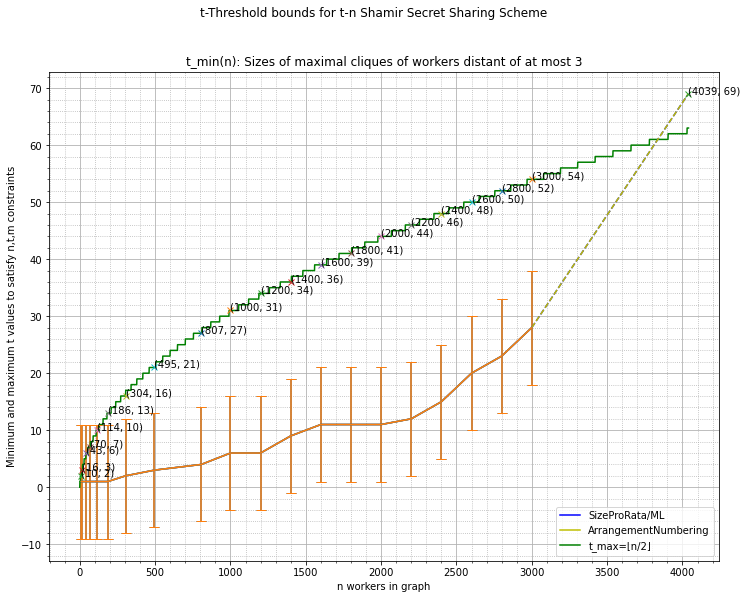

In [242]:
racPosMaxT=lambda x:int(nppol.polyroots([-x-1, 1, 1])[1])
TOver2=lambda n:n//2
maxTbyParticipantsCount(4040,racPosMaxT,[10,16,43,70,114,186,304,495,807,
                             *[200*i for i in range(5,16)]
                             ],maxCliquesPerWorkersandMethod.values.tolist(),"../outputs/max_cliques/tminmax.png")

Empty DataFrame
Columns: []
Index: []
[1, 2, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 1, 1, 2, 1, 1, 2, 1, 1, 1, 1, 2, 2, 2, 2, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 2, 1, 1, 2, 1, 2, 1, 1, 1, 1, 2, 2, 1, 1, 2, 1, 2, 2, 1, 1, 2, 1, 2, 1, 1, 1, 2, 1, 1, 1, 1, 2, 1, 2, 1, 1, 2, 1, 1, 1, 1, 1, 2, 1, 1, 2, 1, 1, 1, 1, 1, 1, 2, 1, 1]
[2, 2, 1, 2, 2, 2, 2, 3, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 2, 2, 1, 1, 2, 2, 2, 2, 2, 2, 1, 2, 1, 2, 1, 1, 2, 2, 1, 2, 3, 2, 1, 2, 2, 3, 2, 1, 2, 2, 3, 1, 1, 1, 1, 2, 2, 2, 1, 2, 2, 3, 2, 1, 1, 2, 2, 2, 1, 2, 2, 2, 1, 1, 1, 2, 2, 1, 2, 1, 2, 2, 2, 2, 1, 1, 2, 3, 1, 1, 2, 1, 1, 1, 1, 2, 2, 3, 1, 2]
[3, 3, 2, 3, 3, 3, 2, 3, 2, 2, 2, 2, 2, 4, 3, 4, 2, 3, 3, 2, 3, 3, 3, 2, 3, 3, 3, 3, 3, 2, 3, 2, 3, 2, 2, 2, 2, 2, 2, 2, 3, 4, 2, 3, 3, 3, 3, 2, 2, 3, 3, 3, 2, 3, 2, 4, 3, 2, 2, 3, 2, 3, 4, 2, 2, 2, 3, 3, 3, 3, 2, 3, 3, 2, 1, 3, 3, 2, 3, 3, 3, 2, 3, 3, 2, 4, 3, 3, 3, 3, 3, 3, 2, 3, 3, 3, 2, 3, 2, 3]
[3, 3, 3, 3, 5, 5, 3, 4, 3, 3, 4, 2, 2, 5, 4, 5, 3, 3, 4, 2

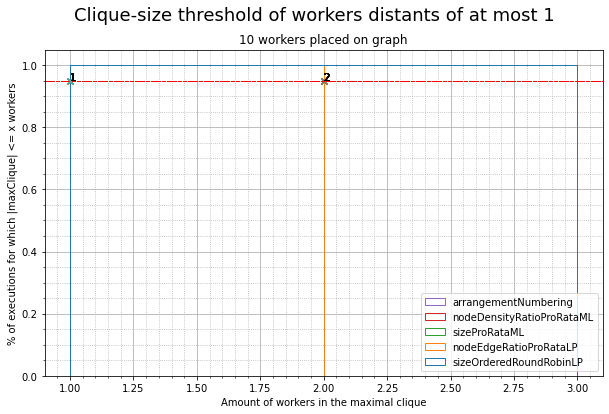

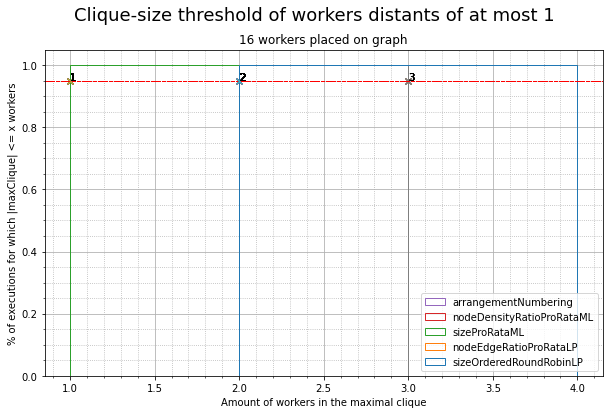

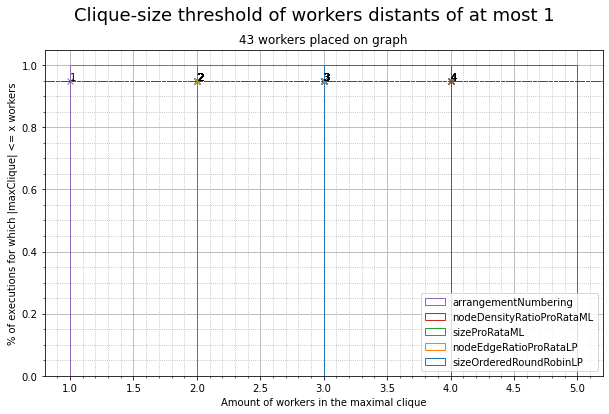

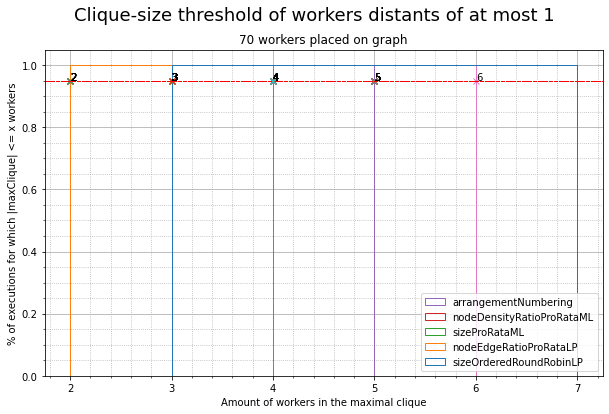

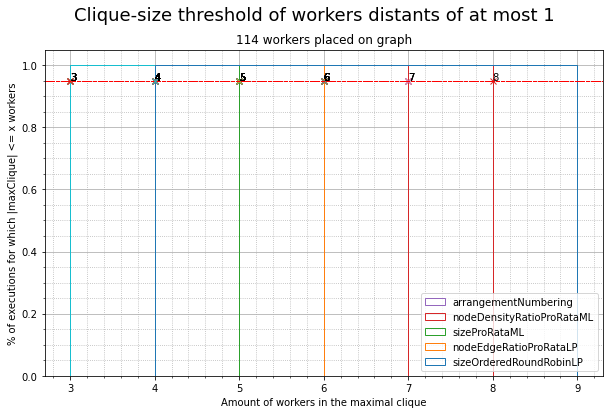

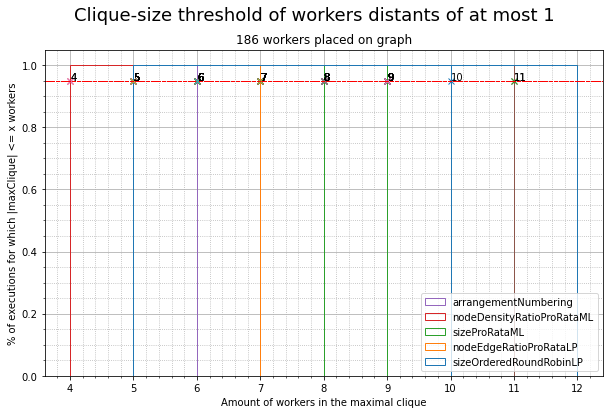

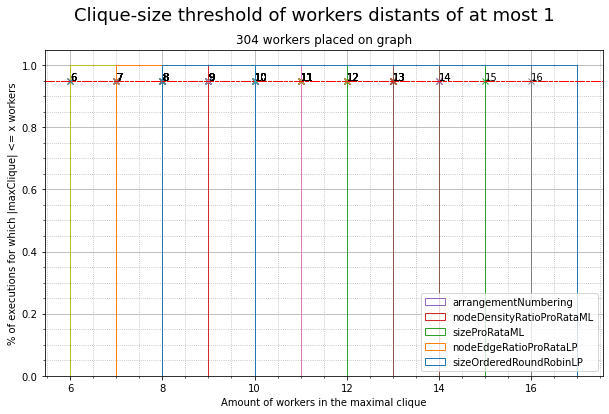

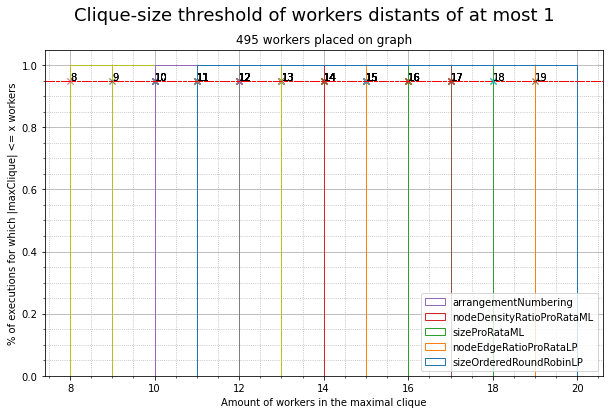

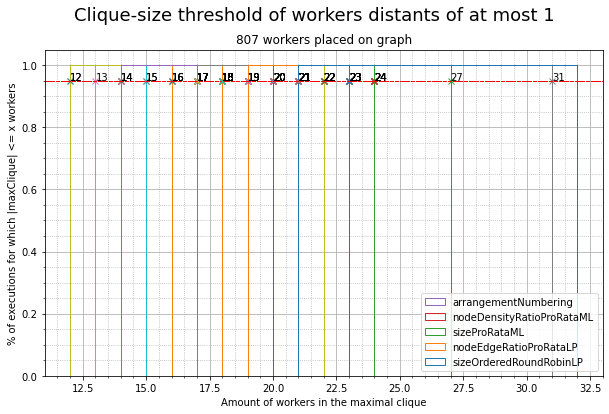

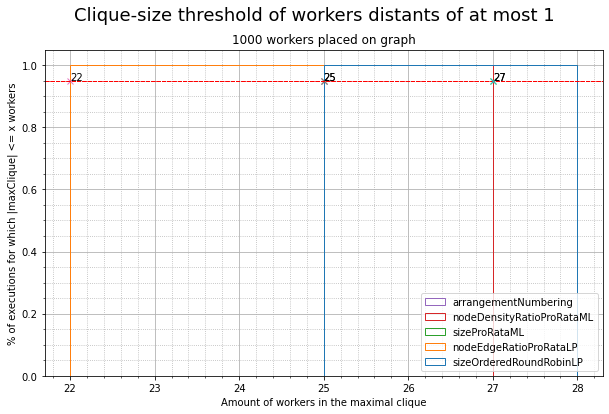

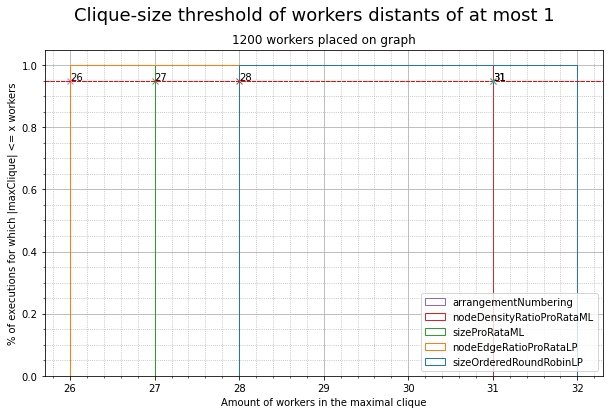

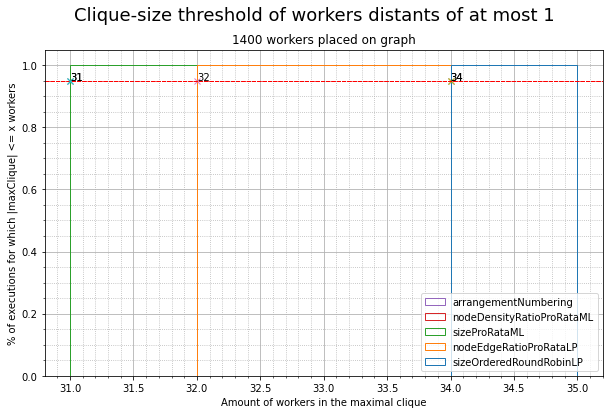

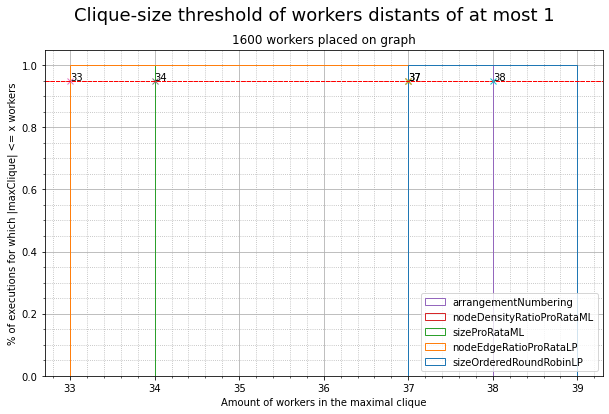

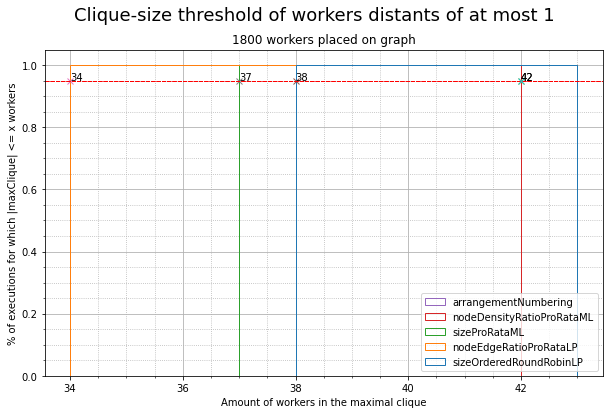

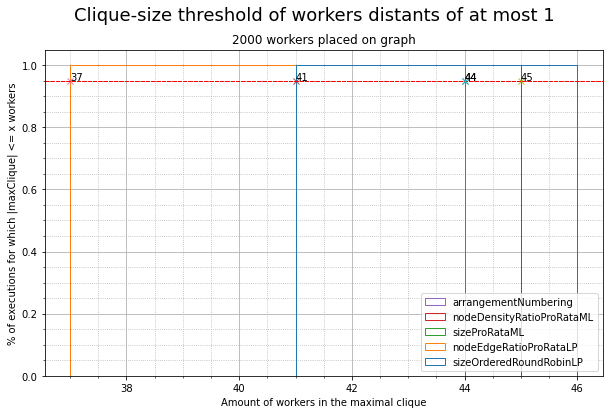

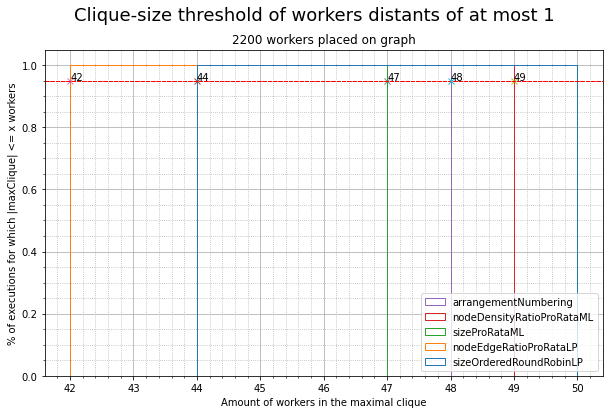

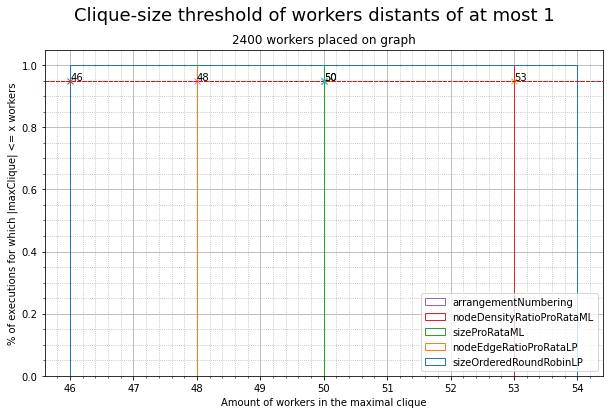

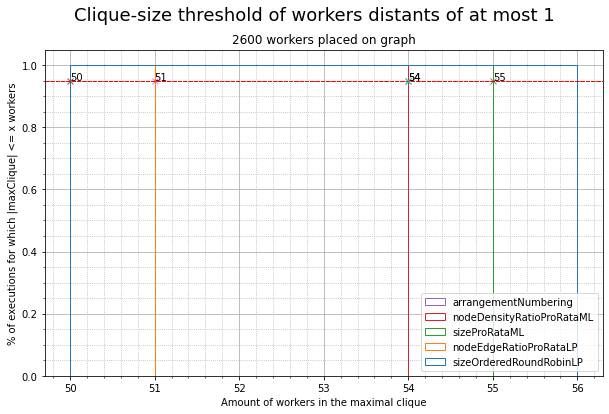

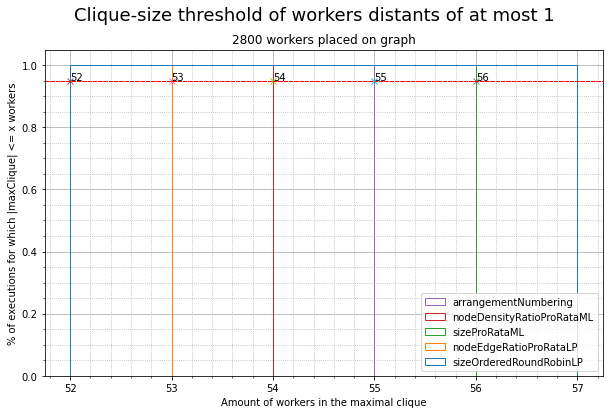

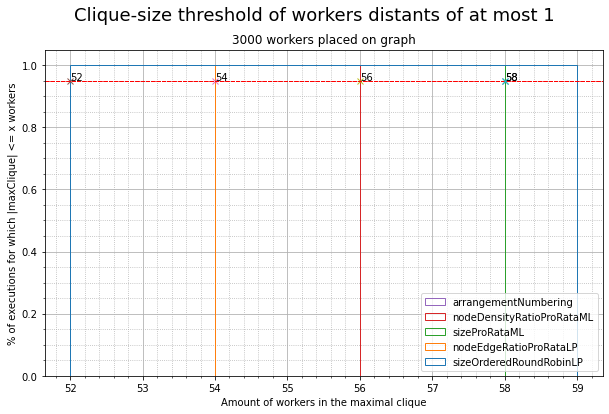

In [320]:

df.head()
df = df[[
    'filename',
    'nWorkers',
    'voterSeed',
    'comDet',
    'assignment',
    'withBoundary',
    'distType',
    'candidates',
    'minDist'
]]
#print(df)
cols = df.columns[:-2].tolist()
maxCliquesPerWorkersandMethodErr=pd.DataFrame()
print(maxCliquesPerWorkersandMethodErr)
for nw in [10,16,43,70,114,186,304,495,807,
          *[200*i for i in range(5,16)]
          ]:
    conditions=[
        
            #df["voterSeed"].isin(["NA"])\
            #& df["withBoundary"].isin([True])\
            #& df["assignment"].isin(["sizeProRataWorkerAssignement"])\
            #& df["comDet"].isin(["community_multilevel"])\
            #& df["nWorkers"].isin([nw])\
            #,
        
            df["voterSeed"].isin([i])\
            & df["nWorkers"].isin([nw])\
            & df["assignment"].isin(["generateArrangementNumber"]) for i in range(100 if nw<=807 else 5)
               ]
    cliqueSizes=[]
    for condition in conditions:
        groupDf = df.where(condition).dropna().groupby(by=cols)[['candidates', 'minDist']].apply(formatToDict)
        cliqueNumber = [ { k:len(v) for k,v in element.items() } for element in groupDf ]
        cliqueSize = [ { k:len(v[0]) for k,v in element.items() } for element in groupDf ]
        cliqueSizes.append(cliqueSize)
    #print(cliqueSizes)
    threshold=0.95
    for minDist in range(1,2):
        cliqueSizeByMinDist = [[ element.get(minDist) for element in cliqueSize if element.get(minDist) is not None]
                                  for cliqueSize in cliqueSizes]
        plotData={"suptitle":"Clique-size threshold of workers distants of at most {}".format(minDist),
                 "title":"{} workers placed on graph".format(nw),
                 }
        thresholds=workerThreshold(cliqueSizeByMinDist, minDist, threshold,plotData)
        print(thresholds)
        if len(thresholds)<100:
            thresholds.extend([0] * (100 - len(thresholds)))
        maxCliquesPerWorkersandMethodErr[nw]=thresholds
#maxCliquesPerWorkersandMethod.index=[

                                     #"sizeProRataML",

                                #"arrangementNumbering",]

In [322]:
import math
t_alpha=1.95
t_alpha_stu=2.132 
print(maxCliquesPerWorkersandMethod)
means=maxCliquesPerWorkersandMethodErr[[10,16,43,70,114,186,304,495,807]].mean()
stds=maxCliquesPerWorkersandMethodErr[[10,16,43,70,114,186,304,495,807]].std()
small=maxCliquesPerWorkersandMethodErr[[200*i for i in range(5,16)]].head(5).mean()
smallStd=maxCliquesPerWorkersandMethodErr[[200*i for i in range(5,16)]].head(5).std()
print(maxCliquesPerWorkersandMethodErr[[200*i for i in range(5,16)]].head(5))
for i in range(5,16):
    means[200*i]=small[200*i]
    stds[200*i]=smallStd[200*i]

print(stds.values)
errorInterval=lambda series,t_alpha: [(t_alpha if k<=807 else t_alpha_stu)*v/math.sqrt(100 if k<=807 else 5) for k,v in series.items()]
errors=pd.Series(errorInterval(stds,t_alpha), index=stds.index)
erroredValues=pd.concat([means, errors], axis=1)
erroredValues.columns=["mean","error"]
print(erroredValues)

                      10   16   43   70   114  186  304  495  807
sizeProRataML           3    6   17   29   47   76  125  204  333
arrangementNumbering    3    6   17   29   47   76  125  204  333
   1000  1200  1400  1600  1800  2000  2200  2400  2600  2800  3000
0    25    28    34    37    38    41    44    46    50    52    52
1    22    26    32    33    34    37    42    48    51    53    54
2    25    27    31    34    37    44    47    50    55    56    58
3    27    31    34    37    42    45    49    53    54    54    56
4    27    31    31    38    42    44    48    50    54    55    58
[0.45604802 0.58741    0.60669664 0.87726619 1.05006012 1.54213547
 2.1057641  2.41284442 3.16476817 2.04939015 2.30217289 1.51657509
 2.16794834 3.43511281 3.27108545 2.91547595 2.60768096 2.16794834
 1.58113883 2.60768096]
       mean     error
10     1.29  0.088929
16     1.72  0.114545
43     2.66  0.118306
70     3.59  0.171067
114    4.78  0.204762
186    6.84  0.300716
304    9.51  0.

In [335]:
import numpy.polynomial.polynomial as nppol
def maxTbyParticipantsCount(maxParticipants, funct, interestValues, errorPlot=None, addedPlot=None, imgPath=None):
    assert all([i <=maxParticipants for i in interestValues])
    colors=['b','y','g','r', 'c', 'm', 'k', 'w']
    fig, ax=plt.subplots(nrows=1,ncols=1, figsize=(12,9))
    racPosMaxT=funct
    maxTs=[racPosMaxT(x) for x in range(maxParticipants+1)]
        
    ax.plot(range(maxParticipants+1),maxTs, color='g')
        
    if errorPlot is not None:
        ax.errorbar(errorPlot.index,errorPlot["mean"],yerr=errorPlot["error"],ecolor="black",barsabove=True, capsize=5, color='r')
        ax.plot([3000,4039],[errorPlot["mean"][3000],69],color="r",linestyle='dashed')
        
    if addedPlot is not None:
        ax.plot(interestValues,addedPlot, color="b",marker='+')
        ax.plot([interestValues[-1],4039],[addedPlot[-1],69],color="b",linestyle='dashed')
        
    ax.set_xlabel("n workers in graph")
    ax.set_ylabel("Minimum and maximum t values to satisfy n,t,m constraints")
    ax.minorticks_on()
    ax.grid(which="minor",linestyle=':')
    ax.grid(which="major",linestyle='-')
    ax.legend(loc='lower right',labels=["t_max=⌊n/2⌋","ArrangementNumbering","SizeProRata/ML"])
    for value in interestValues:
        maxT=maxTs[value]
        ax.plot(value,maxT, marker='x', label="()")
        ax.annotate('(%s, %s)' % (value,maxT), xy=(value,maxT), textcoords='data')
    ax.plot(4039,69, marker='x', label="()")
    ax.annotate('(%s, %s)' % (4039,69), xy=(4039,69), textcoords='data')
    fig.suptitle("t-Threshold bounds for t-n Shamir Secret Sharing Scheme")
    ax.set_title("t_min(n): Sizes of maximal cliques of workers distant of at most 1")
    if imgPath is not None:
        fig.savefig(imgPath)
    #plt.close(fig)

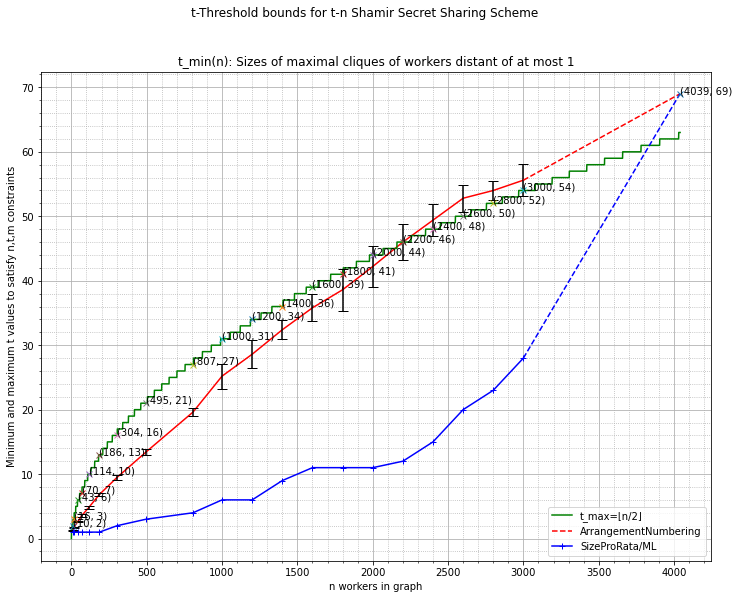

In [336]:
racPosMaxT=lambda x:int(nppol.polyroots([-x-1, 1, 1])[1])
TOver2=lambda n:n//2
maxTbyParticipantsCount(4040,racPosMaxT,[10,16,43,70,114,186,304,495,807,
                             *[200*i for i in range(5,16)]
                             ],erroredValues,maxCliquesPerWorkersandMethod.values.tolist()[0],"../outputs/max_cliques/tminmax.png")